In [23]:
#from xml.dom import minidom
#import collections

import os
import cv2
import random

import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
%matplotlib inline

from getStatsUtils import get_stats, Country_stats

import yaml

In [27]:
# Read YAML file
with open("config.yaml", 'r') as stream:
    config_file = yaml.safe_load(stream)

DATASET_SRC_DIR = config_file['dataset_src_dir']
# DATASET_SRC_DIR = os.getcwd()
imageSetsPath = os.path.join(os.getcwd(), 'ImageSets/')

COUNTRIES = list(config_file['countries'].values())

# Read YAML file
with open("dataset.yaml", 'r') as stream:
    data_loaded = yaml.safe_load(stream)
    
CLASSES = list(data_loaded['names'].values())
NEW_DATASET_DIR = data_loaded['path']
VAL_PATH = os.path.join(NEW_DATASET_DIR, data_loaded['val'])
TRAIN_PATH = os.path.join(NEW_DATASET_DIR, data_loaded['train'])
classes_dict = {"D00": "Longitude cracks", "D10": "Lateral", "D20": "Alligator", "D40": "Pothole"}

# Statistical information on the data

In [3]:
country_stats = []

for country in COUNTRIES:
    src_dir_annot = DATASET_SRC_DIR +'/'+ country +'/train' + '/annotations/' + "xmls/"
    src_dir_img = DATASET_SRC_DIR +'/'+ country +'/train' + '/images/'
    country_stats.append(get_stats(src_dir_annot, country, imageSetsPath))

In [4]:
def display_stats(country_stat: Country_stats):
    print("Country: ", country_stat.country_name)
    print("# of images：" + str(country_stat.total_images))
    print("# of labels：" + str(country_stat.number_of_labels))
    print('# of images with object: ' + str(country_stat.total_images_with_detection))

    for cls in country_stat.images_per_class.keys():
        print(str(cls) + ' : ' + str(country_stat.images_per_class[cls]))
    sns.set_palette("winter", len(country_stat.images_per_class))
    sns.barplot(x=list(country_stat.images_per_class.keys()), y= list(country_stat.images_per_class.values())).set(title=country_stat.country_name)
    plt.show()


#### Stats per country

Country:  China_Drone
# of images：2401
# of labels：3840
# of images with object: 2396
D10 : 1263
D40 : 86
D00 : 1426
Repair : 769
D20 : 293
Block crack : 3


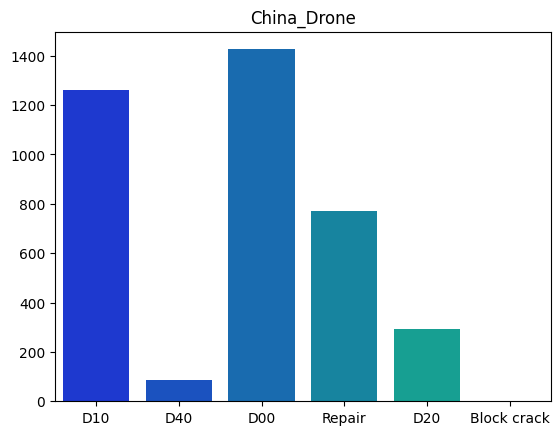

In [5]:
total_images_per_class = {'D10': 0, 'D40': 0, 'D00': 0, 'D20': 0}
total_images=number_of_labels=total_images_with_detection = 0
for x in country_stats:
    display_stats(x)
    total_images += x.total_images
    number_of_labels += x.number_of_labels
    total_images_with_detection += x.total_images_with_detection
    for cls in total_images_per_class:
        total_images_per_class[cls] += x.images_per_class[cls]


### Stats all countries

All countries:
# of images：2401
# of labels：3840
# of images with object: 2396
D10 : 1263
D40 : 86
D00 : 1426
D20 : 293


[Text(0.5, 1.0, 'All countries')]

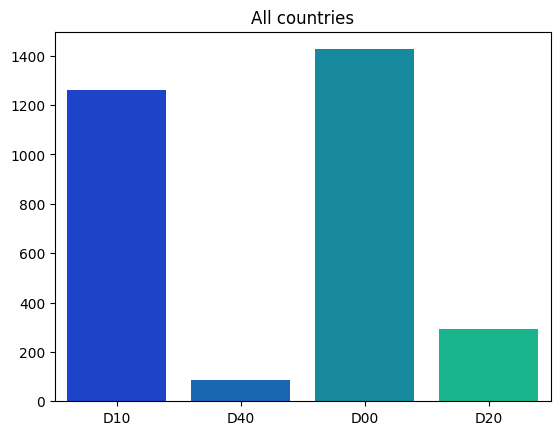

In [6]:
print("All countries:")
print("# of images：" + str(total_images))
print("# of labels：" + str(number_of_labels))
print('# of images with object: ' + str(total_images_with_detection))

for cls in total_images_per_class.keys():
    print(str(cls) + ' : ' + str(total_images_per_class[cls]))
sns.set_palette("winter", len(total_images_per_class))
sns.barplot(x=list(total_images_per_class.keys()), y= list(total_images_per_class.values())).set(title="All countries")

# Visualize some images

In [7]:
from visualizeImages import draw_images

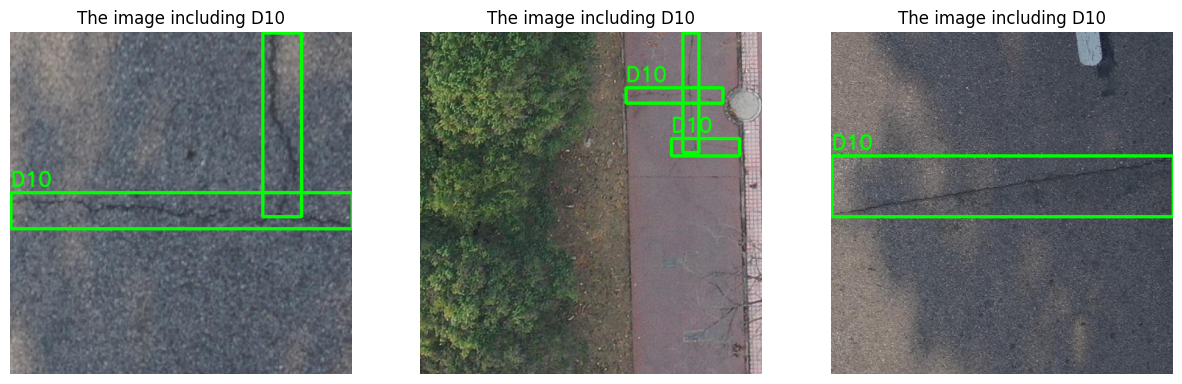

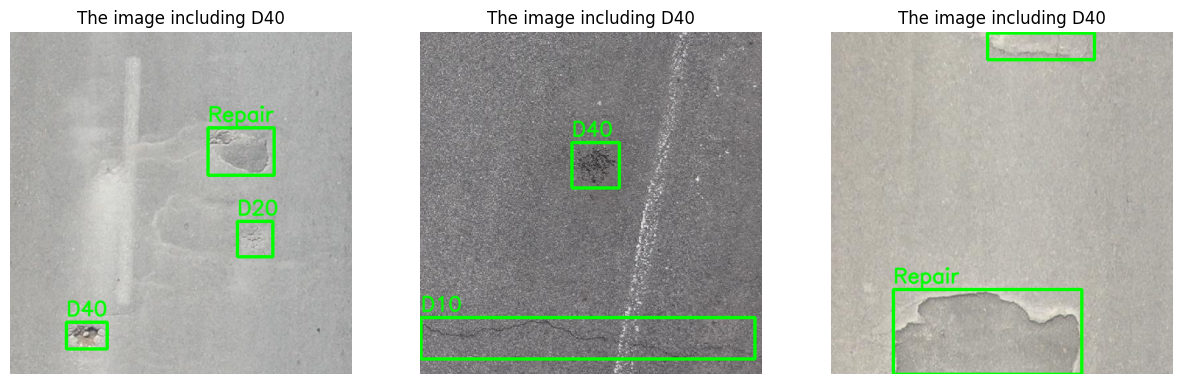

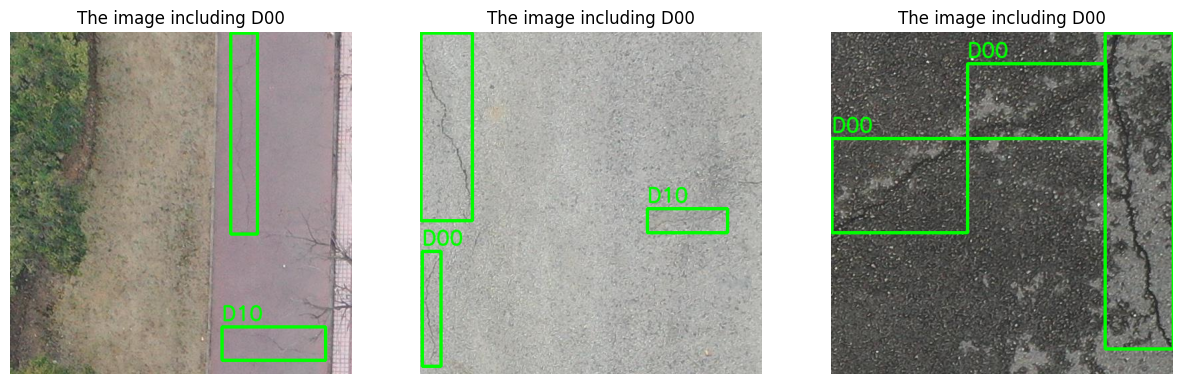

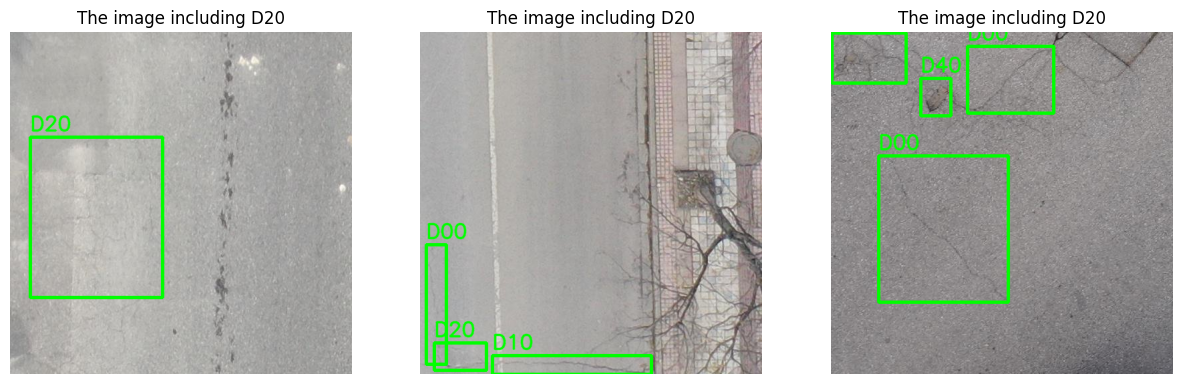

In [8]:
numb_of_images_shown = 3

image_path = './China_Drone/train/images/'
annotation_path = './China_Drone/train/annotations/xmls/'

for damageType in CLASSES:
    tmp = []

    file = open(os.getcwd()+ '/ImageSets/%s_images.txt' %damageType, 'r')

    for line in file:
        line = line.strip('\n')
        tmp.append(line + '.xml')
        
    random.shuffle(tmp)
    fig = plt.figure(figsize=(15,15))
    
    for number, image in enumerate(tmp[0:numb_of_images_shown]):
        country = '_'.join(image.split('_')[:-1])
        image_path = os.path.join(DATASET_SRC_DIR, f'{country}/train/images/')
        annotation_path = os.path.join(DATASET_SRC_DIR, f'{country}/train/annotations/xmls/')
        img = draw_images(image, image_path, annotation_path)
        plt.subplot(1,numb_of_images_shown,number+1)
        plt.axis('off')
        plt.title('The image including ' + damageType)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Convert VOC into YOLO

### Move all training images and annotations into one folder for all countries

In [9]:
if not os.path.exists('./datasets/RDD2022/annotations/'):
    os.makedirs(os.getcwd() +'/datasets/RDD2022/annotations')
if not os.path.exists('./datasets/RDD2022/images/'):
    os.makedirs(os.getcwd() +'/datasets/RDD2022/images')

In [10]:
new_dir_annot = os.path.join(NEW_DATASET_DIR, 'annotations')
new_dir_imgs = os.path.join(NEW_DATASET_DIR, 'images')

In [11]:
NEW_DATASET_DIR

'./datasets/RDD2022'

In [12]:
new_dir_annot

'./datasets/RDD2022/annotations'

In [13]:
import shutil

country_stats = []

for country in CLASSES:
    src_dir_annot = DATASET_SRC_DIR +'/'+ country +'/train' + '/annotations/' + "xmls"
    src_dir_img = DATASET_SRC_DIR +'/'+ country +'/train' + '/images'
    file_list = [filename.strip('.xml') for filename in os.listdir(src_dir_annot)]
    for file in file_list:
        annot_path = src_dir_annot + '/' + file +'.xml'
        annot_dest = new_dir_annot + '/' + file +'.xml'
        img_path = src_dir_img + '/' + file+ '.jpg'
        img_dest = new_dir_imgs + '/' + file+ '.jpg'
        shutil.copyfile(annot_path, annot_dest)
        shutil.copyfile(img_path, img_dest)

### Convert annotations to yolo format

In [33]:
from xml2yolo import xml_to_yolo
input_dir = new_dir_annot
label_dir = os.path.join(NEW_DATASET_DIR , 'labels')
image_dir = new_dir_imgs
valid_classes = CLASSES
xml_to_yolo(input_dir, label_dir, image_dir, valid_classes)

# Split in val and train

In [34]:
image_dir

'./datasets/RDD2022/images'

In [38]:
import glob
import random
files = glob.glob(os.path.join(image_dir, '*.jpg'))
random.shuffle(files)

folders = config_file['split']
check_sum = sum([folders[x] for x in folders])
assert check_sum == 1.0, "Split proportion is not equal to 1.0"

In [39]:
'/'.join(files[1].split('/')[-2:])

'images/China_Drone_001824.jpg'

In [42]:
split_point = round(len(files)*folders['train'])

with open(TRAIN_PATH, 'w+') as file:
    file.write('\n'.join(str('./'+'/'.join(line.split('/')[-2:])) for line in files[:split_point]))

with open(VAL_PATH, 'w+') as file:
    file.write('\n'.join(str('./'+'/'.join(line.split('/')[-2:])) for line in files[split_point:]))

print('# of train: ', split_point)
print('# of val: ', str(len(files)-split_point))


# of train:  1921
# of val:  480


# Model